# Fake News Detection Challenge KDD 2020

https://www.kaggle.com/competitions/fakenewskdd2020

- `text`: text of the article

- `label`: a label that marks the article as potentially unreliable
    - `0`: real
    - `1`: fake

In [2]:
# import package
import pandas as pd

# Dataset
Read the KDD_raw.csv and delete the rows with missing values.

In [3]:
# load data
df = pd.read_csv('KDD_raw.csv', sep='\t', encoding='utf-8')
print(f"Data shape: {df.shape}")
print(df.head())

Data shape: (4987, 2)
                                                text label
0  Get the latest from TODAY Sign up for our news...     1
1  2d  Conan On The Funeral Trump Will Be Invited...     1
2  It’s safe to say that Instagram Stories has fa...     0
3  Much like a certain Amazon goddess with a lass...     0
4  At a time when the perfect outfit is just one ...     0


# Data Cleaning

In [4]:
# check NaN values
print(f"Null values in data:")
print(df.isnull().sum())

Null values in data:
text     0
label    0
dtype: int64


In [5]:
# print unique labels
print(f"Unique labels in data:")
print(df['label'].unique())

Unique labels in data:
['1' '0' 'label']


## Delete the data whose label is not ['0', '1']

since our label can only contains:
- `0`: real
- `1`: fake

In [6]:
# find the row that label == 'label'
print(f"Rows with label 'label': ")
print(df[df['label'] == 'label'])

Rows with label 'label': 
         text  label
1615  content  label


In [7]:
# remove the row that label == 'label'
df = df[df['label'] != 'label']

In [8]:
# save labels as int type
df['label'] = df['label'].astype(int)

In [9]:
# reset the index
df.reset_index(drop=True, inplace=True)

# info
print(df.info())
print(df.head())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4986 entries, 0 to 4985
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4986 non-null   object
 1   label   4986 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.0+ KB
None
                                                text  label
0  Get the latest from TODAY Sign up for our news...      1
1  2d  Conan On The Funeral Trump Will Be Invited...      1
2  It’s safe to say that Instagram Stories has fa...      0
3  Much like a certain Amazon goddess with a lass...      0
4  At a time when the perfect outfit is just one ...      0
(4986, 2)


# Train Test Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Define the split sizes
train_size = 0.90
test_size = 0.10

# split into train and test
train_df, test_df = train_test_split(df, train_size=train_size, test_size=test_size, stratify=df['label'])

In [12]:
print(f'Raw data set size: {len(df)}')
print(f'Training set size: {len(train_df)}')
print(f'Test set size: {len(test_df)}')

Raw data set size: 4986
Training set size: 4487
Test set size: 499


## Output

In [13]:
train_df.to_csv('train.csv', sep='\t', index=False, encoding='utf-8')
print(f"Training data saved as train.csv")
test_df.to_csv('test.csv', sep='\t', index=False, encoding='utf-8')
print(f"Test data saved as test.csv")

Training data saved as train.csv
Test data saved as test.csv


# EDA

In [14]:
import matplotlib.pyplot as plt
import numpy as np

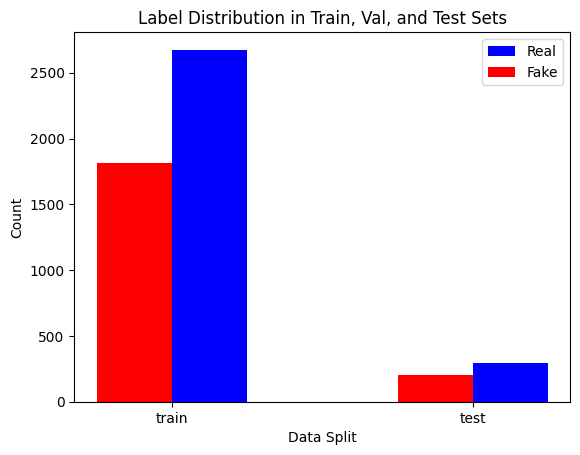

In [15]:
# Count the occurrences of 'fake' and 'real' in each split
train_counts = train_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Combine the counts into a single DataFrame for plotting
counts_df = pd.DataFrame({
    'train': train_counts,
    'test': test_counts
}).T

# Plotting
fig, ax = plt.subplots()

# Define the bar width
bar_width = 0.25

# Set position of bar on X axis
r1 = range(len(counts_df))
r2 = [x + bar_width for x in r1]

# Make the plot
ax.bar(r2, counts_df[0], color='b', width=bar_width, label='Real')
ax.bar(r1, counts_df[1], color='r', width=bar_width, label='Fake')

# Add labels
ax.set_xlabel('Data Split')
ax.set_ylabel('Count')
ax.set_title('Label Distribution in Train, Val, and Test Sets')
ax.set_xticks([r + bar_width/2 for r in range(len(counts_df))])
ax.set_xticklabels(counts_df.index)

# Add legend
ax.legend()

# Show the plot
plt.show()

# Add BERT Embeddings

In [16]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from transformers import AutoTokenizer, AutoModel

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased", clean_up_tokenization_spaces=True)
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased").to(device)

In [18]:
def generate_bert_embeddings(text):
    # Tokenize the input text
    inputs = bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    
    # Get the BERT embeddings
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    # get the cls token embedding
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()   # (1, 768)

    # flatten the embeddings
    embeddings = embeddings.flatten()   # (768,)
    
    return embeddings

In [19]:
# Generate BERT embeddings for each row of text in the DataFrame
train_df['bert_embeddings'] = train_df['text'].apply(generate_bert_embeddings)
test_df['bert_embeddings'] = test_df['text'].apply(generate_bert_embeddings)

# display the embeddings
print(train_df['bert_embeddings'].head())
print(test_df['bert_embeddings'].head())

625     [-0.58505154, -0.23033476, 0.08503331, -0.6579...
3034    [-0.46412155, -0.8269299, 0.15971911, -0.01749...
2752    [-0.22449817, -0.519732, -0.37834272, -0.22955...
4925    [-0.538204, -0.093839385, 0.3541537, 0.0189483...
4780    [-0.031492554, -0.3493325, 0.70149493, 0.06709...
Name: bert_embeddings, dtype: object
1465    [-0.38056096, -0.7548965, -0.5671339, 0.100669...
3733    [-0.22100897, 0.1336792, 0.446061, -0.18849379...
3547    [-0.43542513, -1.3586173, -0.15633087, -0.0795...
2461    [-0.041253213, -0.7142504, -0.2685204, -0.0068...
3395    [-0.6043445, -0.53224844, -0.42417797, -0.5617...
Name: bert_embeddings, dtype: object


# Add RoBERTa Embeddings

In [20]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from transformers import AutoTokenizer, AutoModel

roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base", clean_up_tokenization_spaces=True)
roberta_model = AutoModel.from_pretrained("roberta-base").to(device)

In [22]:
def generate_roberta_embeddings(text):
    # Tokenize the input text
    inputs = roberta_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    
    # Get the RoBERTa embeddings
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    
    # get the cls token embedding
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()   # (1, 768)

    # flatten the embeddings
    embeddings = embeddings.flatten()   # (768,)
    
    return embeddings

In [23]:
# Generate RoBERTa embeddings for each row of text in the DataFrame
train_df['roberta_embeddings'] = train_df['text'].apply(generate_roberta_embeddings)
test_df['roberta_embeddings'] = test_df['text'].apply(generate_roberta_embeddings)

# display the embeddings
print(train_df['roberta_embeddings'].head())
print(test_df['roberta_embeddings'].head())

625     [-0.07220477, 0.08664565, -0.0051694377, -0.16...
3034    [-0.054015182, 0.06155525, 0.020496445, -0.175...
2752    [-0.05114577, 0.055954624, -0.006528543, -0.14...
4925    [-0.038301665, 0.05653024, 0.02677432, -0.1539...
4780    [-0.05443966, 0.070664205, 0.0025050312, -0.16...
Name: roberta_embeddings, dtype: object
1465    [-0.04004512, 0.088101245, 0.01712712, -0.1299...
3733    [-0.0648468, 0.08484085, -0.000743352, -0.1419...
3547    [-0.06510144, 0.08425536, -0.007948116, -0.121...
2461    [-0.02930983, 0.09134884, 0.020709824, -0.1537...
3395    [-0.036446996, 0.08447648, 0.023451367, -0.141...
Name: roberta_embeddings, dtype: object


In [28]:
display(train_df.head())
display(test_df.head())

,text,label,bert_embeddings,roberta_embeddings
625,As the couple deny fresh cheating and divorce ...,0,"[-0.58505154, -0.23033476, 0.08503331, -0.6579...","[-0.07220477, 0.08664565, -0.0051694377, -0.16..."
3034,[This story contains spoilers from Grey's Anat...,0,"[-0.46412155, -0.8269299, 0.15971911, -0.01749...","[-0.054015182, 0.06155525, 0.020496445, -0.175..."
2752,CHERRY Seaborn is the fiancée and childhood sw...,0,"[-0.22449817, -0.519732, -0.37834272, -0.22955...","[-0.05114577, 0.055954624, -0.006528543, -0.14..."
4925,"The 2018 Golden Globes, hosted by Seth Meyers,...",1,"[-0.538204, -0.093839385, 0.3541537, 0.0189483...","[-0.038301665, 0.05653024, 0.02677432, -0.1539..."
4780,The gang’s all here! With just days to go bef...,0,"[-0.031492554, -0.3493325, 0.70149493, 0.06709...","[-0.05443966, 0.070664205, 0.0025050312, -0.16..."


,text,label,bert_embeddings,roberta_embeddings
1465,Chris Evans and Jenny Slate's relationship was...,0,"[-0.38056096, -0.7548965, -0.5671339, 0.100669...","[-0.04004512, 0.088101245, 0.01712712, -0.1299..."
3733,Click to email this to a friend (Opens in new ...,0,"[-0.22100897, 0.1336792, 0.446061, -0.18849379...","[-0.0648468, 0.08484085, -0.000743352, -0.1419..."
3547,That '70s Show is an American television perio...,1,"[-0.43542513, -1.3586173, -0.15633087, -0.0795...","[-0.06510144, 0.08425536, -0.007948116, -0.121..."
2461,Lindsay Lohan says she was “racially profiled”...,1,"[-0.041253213, -0.7142504, -0.2685204, -0.0068...","[-0.02930983, 0.09134884, 0.020709824, -0.1537..."
3395,Image Source: Getty / ullstein bild Dtl. The ...,0,"[-0.6043445, -0.53224844, -0.42417797, -0.5617...","[-0.036446996, 0.08447648, 0.023451367, -0.141..."


# Create HugginFace Dataset

In [29]:
from datasets import Dataset, DatasetDict

In [30]:
# Step 1: Create datasets from pandas
train_dataset = Dataset.from_pandas(train_df).remove_columns(['__index_level_0__'])
test_dataset = Dataset.from_pandas(test_df).remove_columns(['__index_level_0__'])

# Step 2: Combine into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# Upload to HuggingFace Hub

In [31]:
dataset_dict.push_to_hub('LittleFish-Coder/Fake_News_KDD2020')

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/LittleFish-Coder/Fake_News_KDD2020/commit/f9d1fe153915ec9536f92a5db17eea06ded8df43', commit_message='Upload dataset', commit_description='', oid='f9d1fe153915ec9536f92a5db17eea06ded8df43', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/LittleFish-Coder/Fake_News_KDD2020', endpoint='https://huggingface.co', repo_type='dataset', repo_id='LittleFish-Coder/Fake_News_KDD2020'), pr_revision=None, pr_num=None)